# Example 3: Wave propagation calculators

Use RVT input motion with:
1. Linear elastic
2. Equivalent linear (e.g., SHAKE)
3. Frequency-dependent equivalent linear

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pysra

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
motion = pysra.motion.SourceTheoryRvtMotion(7.0, 30, "wna")
motion.calc_fourier_amps()

## Create site profile

Create a simple soil profile with a single soil layer with nonlinear properties defined by the Darendeli nonlinear model.

In [4]:
profile = pysra.site.Profile(
    [
        pysra.site.Layer(
            pysra.site.DarendeliSoilType(18.0, plas_index=30, ocr=1, stress_mean=200),
            30,
            400,
        ),
        pysra.site.Layer(pysra.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
).auto_discretize()

## Create the site response calculator

In [5]:
calcs = [
    ("LE", pysra.propagation.LinearElasticCalculator()),
    ("EQL", pysra.propagation.EquivalentLinearCalculator(strain_ratio=0.65)),
    (
        "FDM",
        pysra.propagation.FrequencyDependentEqlCalculator(use_smooth_spectrum=False),
    ),
]

## Specify the output

In [6]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection(
    [
        pysra.output.AccelTransferFunctionOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pysra.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pysra.output.OutputLocation("outcrop", index=0),
        ),
        pysra.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pysra.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pysra.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pysra.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pysra.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pysra.output.MaxStrainProfile(),
        pysra.output.InitialVelProfile(),
        pysra.output.CompatVelProfile(),
    ]
)

## Perform the calculation

Compute the response of the site, and store the state within the calculation object. Use the calculator, to compute the outputs.

In [7]:
calcs

[('LE', <pysra.propagation.LinearElasticCalculator at 0x7f6e2a4cbcc0>),
 ('EQL', <pysra.propagation.EquivalentLinearCalculator at 0x7f6e2a4cb0f0>),
 ('FDM',
  <pysra.propagation.FrequencyDependentEqlCalculator at 0x7f6e2a4cb048>)]

In [8]:
len(profile)

20

In [9]:
properties = {}

for name, calc in calcs:
    calc(motion, profile, profile.location("outcrop", index=-1))
    outputs(calc, name)
    properties[name] = {
        key: getattr(profile[0], key) for key in ["shear_mod_reduc", "damping"]
    }

## Plot the properties of the EQL and EQL-FDM methods

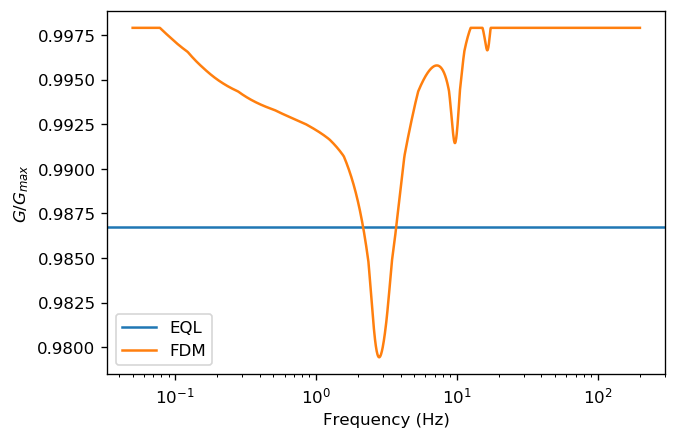

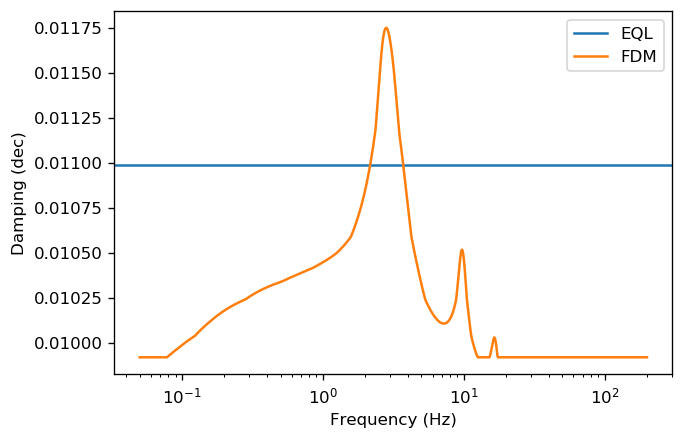

In [10]:
for key in properties["EQL"].keys():
    fig, ax = plt.subplots()

    ax.axhline(properties["EQL"][key], label="EQL", color="C0")
    ax.plot(motion.freqs, properties["FDM"][key], label="FDM", color="C1")

    ax.set(
        ylabel={"damping": "Damping (dec)", "shear_mod_reduc": r"$G/G_{max}$"}[key],
        xlabel="Frequency (Hz)",
        xscale="log",
    )
    ax.legend()

## Plot the outputs

Create a few plots of the output.

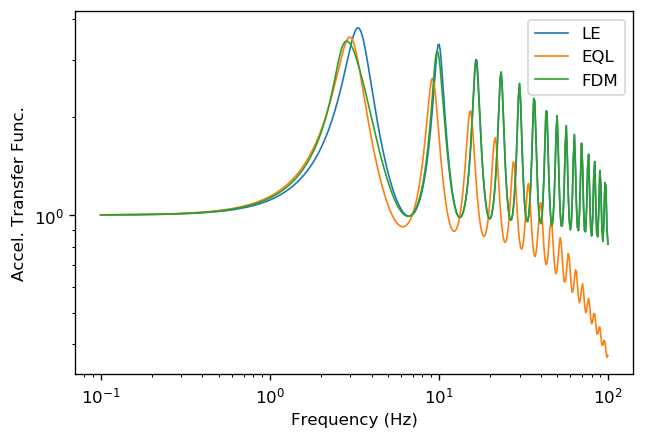

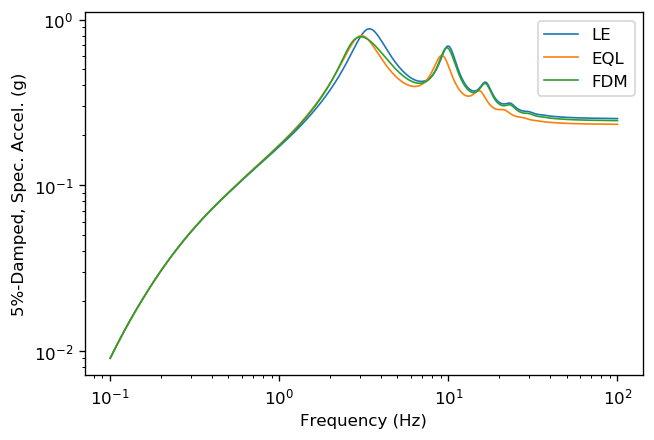

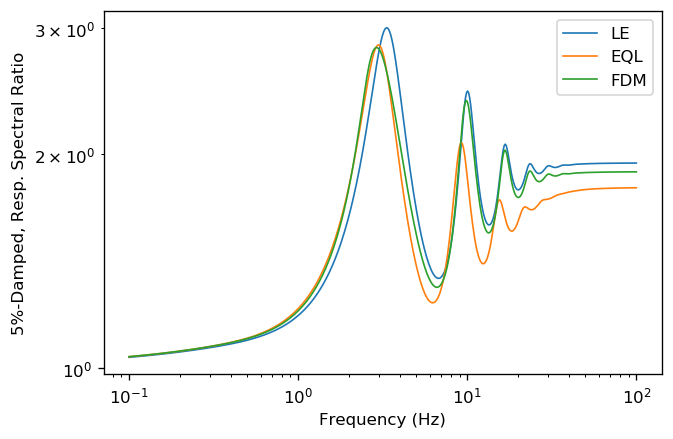

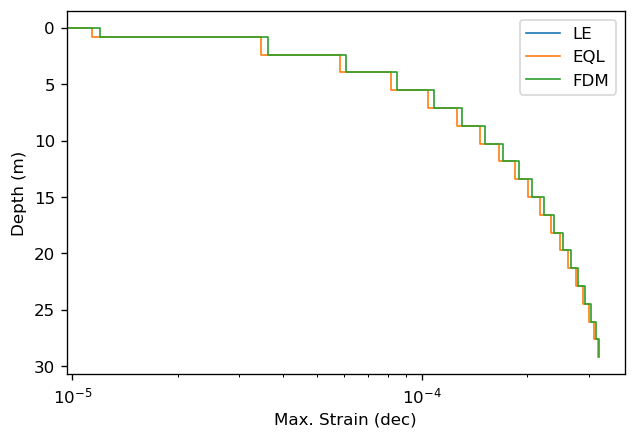

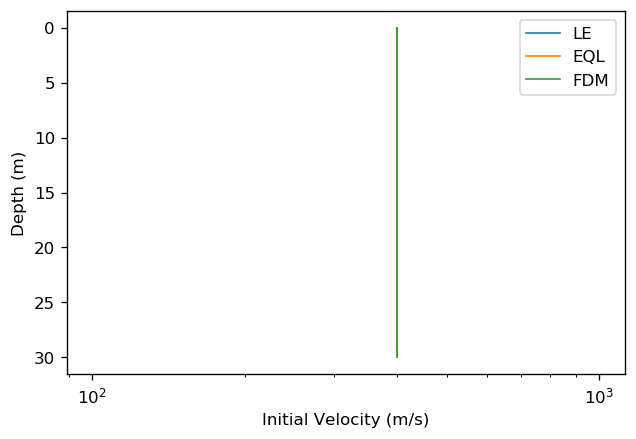

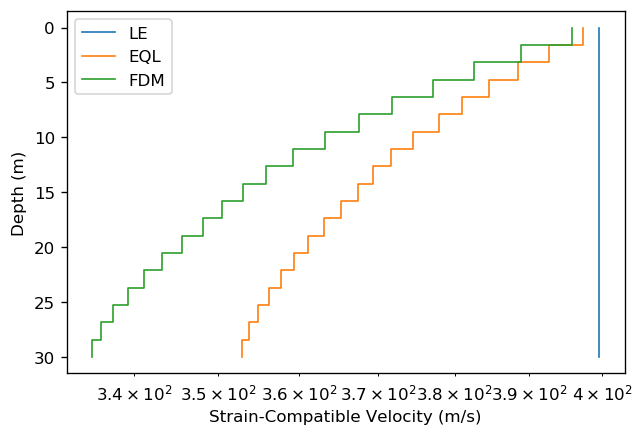

In [11]:
for o in outputs:
    o.plot(style="indiv")

Show how to manually create a plot

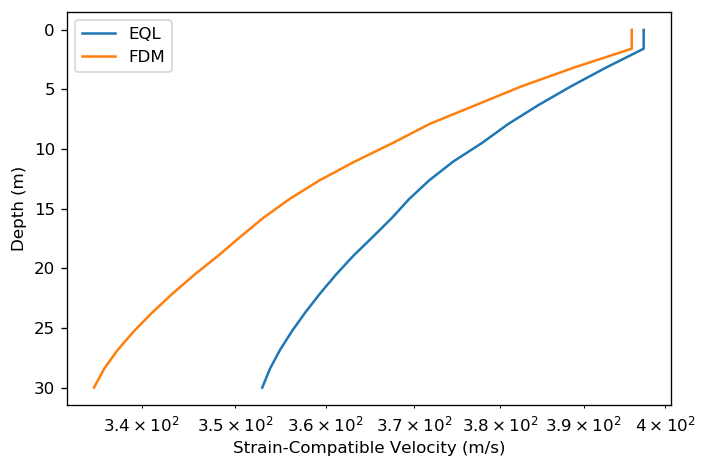

In [12]:
for o in outputs[-1:]:
    fig, ax = plt.subplots()

    for name, refs, values in o.iter_results():
        if name == "LE":
            # No strain results for LE analyses
            continue
        ax.plot(values, refs, label=name)

    ax.set(xlabel=o.xlabel, xscale="log", ylabel=o.ylabel)
    ax.invert_yaxis()
    ax.legend()
    fig.tight_layout();